---
# **LIBRARY**
---

In [1]:
# Library sistem
import os
import gdown
import shutil
import json

# Google spreadsheet API
import gspread
from oauth2client.service_account import ServiceAccountCredentials

# Library dasar
import numpy as np
import pandas as pd

# Library visualisasi
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Library pre-processing data
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Library statistika
from statsmodels.tsa.stattools import acf, pacf

# Library pemodelan
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Bidirectional, GRU, Dropout, Flatten
from keras.callbacks import EarlyStopping
from keras.models import load_model

# Library evaluasi
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

# Library penyetelan hiperparameter
import optuna
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_parallel_coordinate,
    plot_slice,
    plot_contour
)
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

---
# **CONFIGURATION**
---

In [3]:
# ============================
# Configuration
# ============================
# Path data input utama
METADATA_PATH = "../data/processed/(K3 - Transformasi per jam) Beban listrik.csv"  # Pastikan file sudah ada

# Path folder output utama
OUTPUT_PATH = "../hasil/pemodelan"

# File hasil eksperimen (log semua performa model)
EKSPERIMEN_EXCEL_PATH = f"{OUTPUT_PATH}/hasil_eksperimen.xlsx"

# Subfolder untuk hasil model
MODEL_PATH = f"{OUTPUT_PATH}/model"
HISTORY_PATH = f"{OUTPUT_PATH}/history"
GRAFIK_PATH = f"{OUTPUT_PATH}/grafik"
PREDIKSI_PATH = f"{OUTPUT_PATH}/prediksi"
OPTUNA_PATH = f"{OUTPUT_PATH}/optuna"

# Buat semua direktori jika belum ada
for path in [OUTPUT_PATH, MODEL_PATH, HISTORY_PATH, GRAFIK_PATH, PREDIKSI_PATH, OPTUNA_PATH, os.path.dirname(EKSPERIMEN_EXCEL_PATH)]:
    os.makedirs(path, exist_ok=True)

print(f"✅ Output directories ready under: {OUTPUT_PATH}")

✅ Output directories ready under: ../hasil/pemodelan


In [4]:
def simpan_eksperimen(data, file_path=EKSPERIMEN_EXCEL_PATH, sheet_name="raw"):
    # Pastikan direktori ada
    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    kolom = [
        "time", "model", "time_step", "layer", "dense", "dropout_rate",
        "epochs", "batch_size",
        "train_mse", "test_mse", "train_mae", "test_mae",
        "train_rmse", "test_rmse", "train_mape", "test_mape",
        "train_r2", "test_r2"
    ]

    # Data baru
    time = datetime.now().strftime("%d-%m-%Y %H:%M:%S")
    df_new = pd.DataFrame([[time] + list(data)], columns=kolom)

    # Jika file dan sheet sudah ada → load & gabung
    if os.path.exists(file_path):
        try:
            df_lama = pd.read_excel(file_path, sheet_name=sheet_name, engine="openpyxl")
            df_all = pd.concat([df_lama, df_new], ignore_index=True)
        except Exception as e:
            print(f"⚠️ Error membaca sheet lama: {e}")
            df_all = df_new
        mode = "a"
        sheet_option = {"if_sheet_exists": "replace"}
    else:
        df_all = df_new
        mode = "w"
        sheet_option = {}

    # Simpan
    try:
        with pd.ExcelWriter(file_path, engine="openpyxl", mode=mode, **sheet_option) as writer:
            df_all.to_excel(writer, index=False, sheet_name=sheet_name)
        print(f"✅ Data berhasil disimpan ke sheet '{sheet_name}' di {file_path}")
    except Exception as e:
        print(f"❌ Gagal menyimpan data: {e}")


In [5]:
dummy_model = "LSTM"
dummy_timestep = 24
dummy_layer = 2
dummy_dense = [64, 32]
dummy_dropout = 0.2
dummy_epochs = 50
dummy_batch_size = 32

# Metric hasil pelatihan
dummy_train_mse = 0.001
dummy_test_mse = 0.002
dummy_train_mae = 0.01
dummy_test_mae = 0.015
dummy_train_rmse = 0.03
dummy_test_rmse = 0.04
dummy_train_mape = 2.1
dummy_test_mape = 2.5
dummy_train_r2 = 0.98
dummy_test_r2 = 0.97

# Gabungkan semuanya ke tuple sesuai urutan fungsi simpan_eksperimen()
data = (
    dummy_model, dummy_timestep, dummy_layer, dummy_dense,
    dummy_dropout, dummy_epochs, dummy_batch_size,
    dummy_train_mse, dummy_test_mse,
    dummy_train_mae, dummy_test_mae,
    dummy_train_rmse, dummy_test_rmse,
    dummy_train_mape, dummy_test_mape,
    dummy_train_r2, dummy_test_r2
)

# Panggil fungsi
simpan_eksperimen(data)

✅ Data berhasil disimpan ke sheet 'raw' di ../hasil/pemodelan/hasil_eksperimen.xlsx


---
# **LOAD METADATA**
---

In [6]:
# Memanggil data
df_siap = pd.read_csv(METADATA_PATH)
df_siap['TANGGAL_JAM'] = pd.to_datetime(df_siap['TANGGAL_JAM'])
df_siap['TAHUN'] = df_siap['TANGGAL_JAM'].dt.year

---
# **DEEP LEARNING**
---

## **Spliting Data**

In [7]:
def buat_dataset(data, time_step=1):
  X, y = [], []
  for i in range(len(data) - time_step):
    a = data[i:(i + time_step), 0]
    X.append(a)
    y.append(data[i + time_step, 0])
  return np.array(X), np.array(y)

def bagi_data(df, ukuran_pelatihan, time_step, scaler):
  data = df['BEBAN'].values.reshape(-1, 1)
  scaled_data = scaler.fit_transform(data)

  X, y = buat_dataset(scaled_data, time_step)

  X_train, X_test = X[:ukuran_pelatihan], X[ukuran_pelatihan:]
  y_train, y_test = y[:ukuran_pelatihan], y[ukuran_pelatihan:]

  train_data = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1)
  test_data = pd.concat([pd.DataFrame(X_test), pd.DataFrame(y_test)], axis=1)

  X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
  X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

  return train_data, test_data, X_train, X_test, y_train, y_test, scaler

In [8]:
UKURAN_PELATIHAN = int(len(df_siap) * 0.8)
TIME_STEP = 24 #(1 hari)

train_data, test_data, X_train, X_test, y_train, y_test, scaler = bagi_data(df_siap, UKURAN_PELATIHAN, TIME_STEP, MinMaxScaler(feature_range=(0,1)))

In [9]:
print(f"Total : {len(df_siap)}")
print(f"Ukuran pelatihan : {UKURAN_PELATIHAN}")
print(f"X : {len(X_train) + len(X_test)}")
print(f"Train : {len(train_data)} ({len(X_train)},{len(y_train)})")
print(f"Test : {len(test_data)} ({len(X_test)},{len(y_test)})")

Total : 77857
Ukuran pelatihan : 62285
X : 77833
Train : 62285 (62285,62285)
Test : 15548 (15548,15548)


## **Pemodelan**

In [10]:
# Fungsi untuk membangun arsitektur model LSTM
def build_lstm(layer, dense, dropout_rate, time_step):
  model = Sequential()
  model.add(Input(shape=(time_step,1)))
  for i in range(0, layer):
      model.add(LSTM(dense[i], return_sequences=(i < layer - 1)))
      model.add(Dropout(dropout_rate))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mean_squared_error')

  early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
  return model, early_stopping

# Fungsi untuk membangun arsitektur model BiLSTM
def build_bilstm(layer, dense, dropout_rate, time_step):
  model = Sequential()
  model.add(Input(shape=(time_step,1)))
  for i in range(0, layer):
      model.add(Bidirectional(LSTM(dense[i],  return_sequences=(i < layer - 1))))
      model.add(Dropout(dropout_rate))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mean_squared_error')

  early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
  return model, early_stopping

# Fungsi untuk membangun arsitektur model GRU
def build_gru(layer, dense, dropout_rate, time_step):
  model = Sequential()
  model.add(Input(shape=(time_step,1)))
  for i in range(0, layer):
      model.add(GRU(dense[i], return_sequences=(i < layer - 1)))
      model.add(Dropout(dropout_rate))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mean_squared_error')

  early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
  return model, early_stopping

Model yang dibangun di bawah ini hanyalah model-model uji coba saja.

---
### **LSTM**
---

In [10]:
layer = 2
dense = [116, 104]
dropout_rate = 0.1
epochs = 3
batch_size = 512

model_lstm, early_stooping = build_lstm(layer, dense, dropout_rate, TIME_STEP)
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 116)           54752     
                                                                 
 dropout (Dropout)           (None, 24, 116)           0         
                                                                 
 lstm_1 (LSTM)               (None, 104)               91936     
                                                                 
 dropout_1 (Dropout)         (None, 104)               0         
                                                                 
 dense (Dense)               (None, 1)                 105       
                                                                 
Total params: 146,793
Trainable params: 146,793
Non-trainable params: 0
_________________________________________________________________


In [11]:
history_lstm = model_lstm.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stooping], verbose=1)

Epoch 1/3
122/122 [==============================] - 6s 18ms/step - loss: 0.0150 - val_loss: 0.0105
Epoch 2/3
122/122 [==============================] - 2s 14ms/step - loss: 0.0058 - val_loss: 0.0035
Epoch 3/3
122/122 [==============================] - 2s 14ms/step - loss: 0.0037 - val_loss: 0.0028


---
### **BiLSTM**
---

In [12]:
layer = 3
dense = [70,70,70]
dropout_rate = 0.110570919753144
epochs = 3
batch_size = 512

model_bilstm, early_stooping = build_bilstm(layer, dense, dropout_rate, TIME_STEP)
model_bilstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 24, 140)          40320     
 l)                                                              
                                                                 
 dropout_2 (Dropout)         (None, 24, 140)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 24, 140)          118160    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 24, 140)           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 140)              118160    
 nal)                                                            
                                                      

In [13]:
history_bilstm = model_bilstm.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stooping], verbose=1)

Epoch 1/3
122/122 [==============================] - 10s 46ms/step - loss: 0.0140 - val_loss: 0.0078
Epoch 2/3
122/122 [==============================] - 4s 35ms/step - loss: 0.0042 - val_loss: 0.0030
Epoch 3/3
122/122 [==============================] - 4s 36ms/step - loss: 0.0029 - val_loss: 0.0027


---
### **GRU**
---

In [14]:
layer = 2
dense = [116, 104]
dropout_rate = 0.1
epochs = 3
batch_size = 512

model_gru, early_stooping = build_gru(layer, dense, dropout_rate, TIME_STEP)
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 24, 116)           41412     
                                                                 
 dropout_5 (Dropout)         (None, 24, 116)           0         
                                                                 
 gru_1 (GRU)                 (None, 104)               69264     
                                                                 
 dropout_6 (Dropout)         (None, 104)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 105       
                                                                 
Total params: 110,781
Trainable params: 110,781
Non-trainable params: 0
_________________________________________________________________


In [15]:
history_gru = model_gru.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stooping], verbose=1)

Epoch 1/3
122/122 [==============================] - 4s 18ms/step - loss: 0.0104 - val_loss: 0.0041
Epoch 2/3
122/122 [==============================] - 1s 12ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 3/3
122/122 [==============================] - 1s 12ms/step - loss: 0.0022 - val_loss: 0.0022


## **Evaluasi**

In [11]:
def mae(y_true, y_pred, scaler):
    mae_scaled = mean_absolute_error(y_true, y_pred)
    y_true = scaler.inverse_transform(y_true)
    y_pred = scaler.inverse_transform(y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return mae_scaled, mae

def mse(y_true, y_pred, scaler):
    mse_scaled = mean_squared_error(y_true, y_pred)
    y_true = scaler.inverse_transform(y_true)
    y_pred = scaler.inverse_transform(y_pred)
    mse = mean_squared_error(y_true, y_pred)
    return mse_scaled, mse

def mape(y_true, y_pred, scaler):
    mape_scaled = mean_absolute_percentage_error(y_true, y_pred)
    y_true = scaler.inverse_transform(y_true)
    y_pred = scaler.inverse_transform(y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return mape_scaled, mape

def rmse(y_true, y_pred, scaler):
    rmse_scaled = root_mean_squared_error(y_true, y_pred)
    y_true = scaler.inverse_transform(y_true)
    y_pred = scaler.inverse_transform(y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    return rmse_scaled, rmse

def r2(y_true, y_pred, scaler):
    r2_scaled = r2_score(y_true, y_pred)
    y_true = scaler.inverse_transform(y_true)
    y_pred = scaler.inverse_transform(y_pred)
    r2 = r2_score(y_true, y_pred)
    return r2, r2_scaled

In [12]:
def simpan_histori(history_data, filename="test", type="trial", time_step=TIME_STEP):
    history_path = f"{HISTORY_PATH}/{time_step}/{type}"
    os.makedirs(history_path, exist_ok=True)
    
    loss_history = history_data.history['loss']
    val_loss_history = history_data.history['val_loss']
    epochs = range(1, len(loss_history) + 1)

    best_epoch = min(range(len(val_loss_history)), key=val_loss_history.__getitem__) + 1
    best_val_loss = min(val_loss_history)

    df = pd.DataFrame({
        'Epoch': epochs,
        'Training Loss': loss_history,
        'Validation Loss': val_loss_history
    })

    best_epoch_data = pd.DataFrame({
        'Epoch': [best_epoch],
        'Training Loss': [None],
        'Validation Loss': [best_val_loss]
    })

    # Concatenate best epoch row
    df = pd.concat([df, best_epoch_data], ignore_index=True)    
    df.to_csv(f'{history_path}/{filename}.csv', index=False)

    return df

def evaluasi(X_train, X_test, y_train, y_test, time_step, model, scaler, save=[False], verbose=False):
    train_predict = model.predict(X_train, verbose=1)
    test_predict = model.predict(X_test, verbose=1)

    train_data_new = y_train.reshape(-1, 1)
    test_data_new = y_test.reshape(-1, 1)

    mae_train_scaled, mae_train = mae(train_data_new,train_predict,scaler)
    mae_test_scaled, mae_test = mae(test_data_new,test_predict,scaler)
    mse_train_scaled, mse_train = mse(train_data_new,train_predict,scaler)
    mse_test_scaled, mse_test = mse(test_data_new,test_predict,scaler)
    rmse_train_scaled, rmse_train = rmse(train_data_new,train_predict,scaler)
    rmse_test_scaled, rmse_test = rmse(test_data_new,test_predict,scaler)
    mape_train_scaled, mape_train = mape(train_data_new,train_predict,scaler)
    mape_test_scaled, mape_test = mape(test_data_new,test_predict,scaler)
    r2_train_scaled, r2_train = r2(train_data_new,train_predict,scaler)
    r2_test_secaled, r2_test = r2(test_data_new,test_predict,scaler)

    if(save[0]):
        print("Saving history")
        _, model, time_step, layer, dense, dropout_rate, epochs, batch_size = save
        history = [model, time_step, layer, str(dense), dropout_rate, epochs, batch_size, mse_train, mse_test, mae_train, mae_test, rmse_train, rmse_test, mape_train, mape_test, r2_train, r2_test]

        try:
            simpan_eksperimen(history)
        except Exception as e:
            print(f"Error appending row: {e}")

    if(verbose):
        print("Matriks Evaluasi : Train\tTest")
        print(f"MSE : {mse_train}\t{mse_test}")
        print(f"MAE : {mae_train}\t{mae_test}")
        print(f"RMSE : {rmse_train}\t{rmse_test}")
        print(f"MAPE : {mape_train}\t{mape_test}")
        print(f"R2 : {r2_train}\t{r2_test}")

    return train_predict, test_predict, mse_train, mse_test

In [13]:
def plot_evaluasi(time, data_asli, train_predict, test_predict, scaler, title, filename="test", type="trial", time_step=TIME_STEP):
    prediksi_path = f"{PREDIKSI_PATH}/{time_step}/{type}"
    grafik_path = f"{GRAFIK_PATH}/{time_step}/{type}"

    for path in [prediksi_path, grafik_path]:
        os.makedirs(path, exist_ok=True)

    train_predict_rescaled = scaler.inverse_transform(train_predict)
    test_predict_rescaled = scaler.inverse_transform(test_predict)

    empty_values = np.full((time_step, train_predict_rescaled.shape[1]), np.nan)  # Membuat array kosong (NaN) dengan panjang 24
    train_predict_rescaled = np.concatenate((empty_values, train_predict_rescaled), axis=0)

    # Menggabungkan prediksi pelatihan dengan prediksi pengujian
    all_data = np.concatenate((train_predict_rescaled, test_predict_rescaled), axis=0).reshape(-1)

    # Membuat DataFrame dengan kolom waktu dan nilai yang sesuai
    predictions_df = pd.DataFrame({
        'time': time,
        'data_asli': data_asli,
        'prediksi': all_data
    })

    predictions_df.to_csv(f"{prediksi_path}/{filename}.csv", index=False)

    plt.figure(figsize=(10, 6))
    plt.plot(time, data_asli, color='b', label='Data asli', lw=0.5)
    plt.plot(time[time_step:len(train_predict)+time_step], scaler.inverse_transform(train_predict), color='orange', label='Prediksi data pelatihan', alpha=0.95, lw=0.5)
    plt.plot(time[len(train_predict)+time_step:len(data_asli)], scaler.inverse_transform(test_predict), color='r', label='Prediksi data pengujian', alpha=0.95,lw=0.5)
    plt.xlabel('Tanggal')
    plt.xticks(rotation=90)
    plt.ylabel('Beban Listrik (MW)')
    plt.title(f"Prediksi {title}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{grafik_path}/{filename}.png")
    plt.savefig(f"{grafik_path}/{filename}.pdf")
    plt.show()

In [14]:
def plot_prediksi(time, data_asli, train_predict, test_predict, scaler, days, title, filename="test", type="trial", time_step=TIME_STEP):
    grafik_path = f"{GRAFIK_PATH}/{time_step}/{type}"
    os.makedirs(grafik_path, exist_ok=True)
    
    n_data = len(train_predict)+len(test_predict)
    plt.figure(figsize=(10, 6))
    plt.plot(time[n_data-days+time_step:n_data+days+time_step], data_asli[n_data-days+time_step:n_data+days+time_step], color='b', label='Data asli')
    plt.plot(time[n_data-days+time_step:n_data+days+time_step], scaler.inverse_transform(test_predict)[len(test_predict)-days:len(test_predict)], color='r', label='Prediksi data pengujian', alpha=0.8)
    plt.xlabel('Tanggal')
    plt.xticks(rotation=90)
    plt.locator_params(axis='x', nbins=days)
    plt.ylabel('Beban Listrik (MW)')
    plt.title(f"Model {title}")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{grafik_path}/{filename}.png")
    plt.savefig(f"{grafik_path}/{filename}.pdf")
    plt.show()

In [15]:
def plot_loss(history, epochs, title, filename="test", type="trial", time_step=TIME_STEP):
    grafik_path = f"{GRAFIK_PATH}/{time_step}/{type}"
    os.makedirs(grafik_path, exist_ok=True)

    plt.plot(history.history['loss'][:epochs], label='Error pelatihan')
    plt.plot(history.history['val_loss'][:epochs], label='Eror pengujian')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.savefig(f"{grafik_path}/{filename}.png")
    plt.savefig(f"{grafik_path}/{filename}.pdf")
    plt.show()

---
### **LSTM**
---

486/486 [==============================] - 3s 6ms/step
Saving history
✅ Data berhasil disimpan ke sheet 'raw' di ../hasil/pemodelan/hasil_eksperimen.xlsx
Matriks Evaluasi : Train	Test
MSE : 202682.69335376172	224262.08376544356
MAE : 370.64488967375894	379.7334116589051
RMSE : 450.20294685148576	473.56317821959465
MAPE : 0.055620122984152844	0.046630624242188744
R2 : 0.7847687076324669	0.7815445260916931


C:\Users\Lab Matematika\AppData\Local\Temp\ipykernel_22524\2040627452.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, best_epoch_data], ignore_index=True)


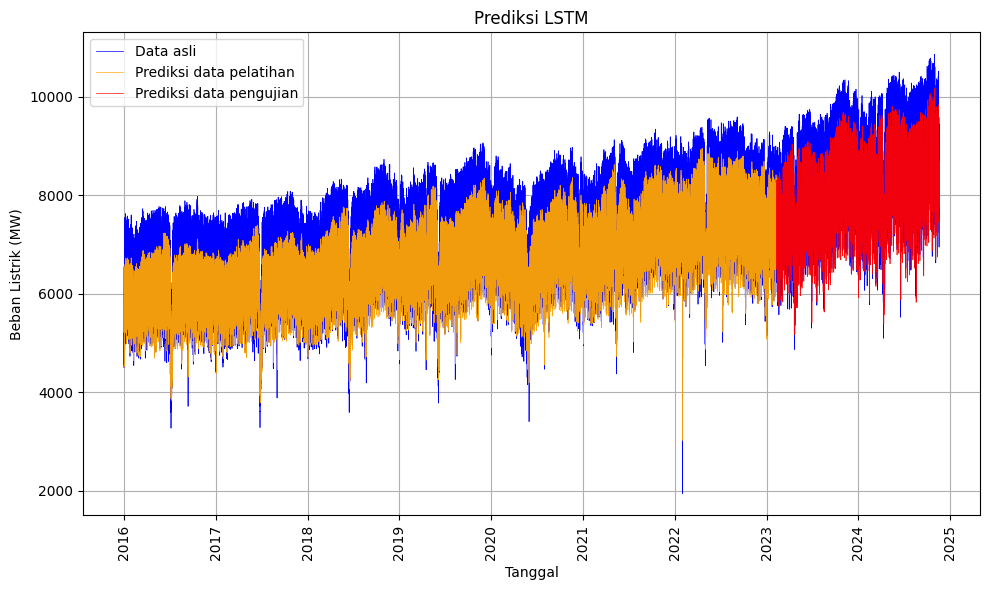

C:\Users\Lab Matematika\AppData\Local\Temp\ipykernel_22524\1031969864.py:11: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=days)


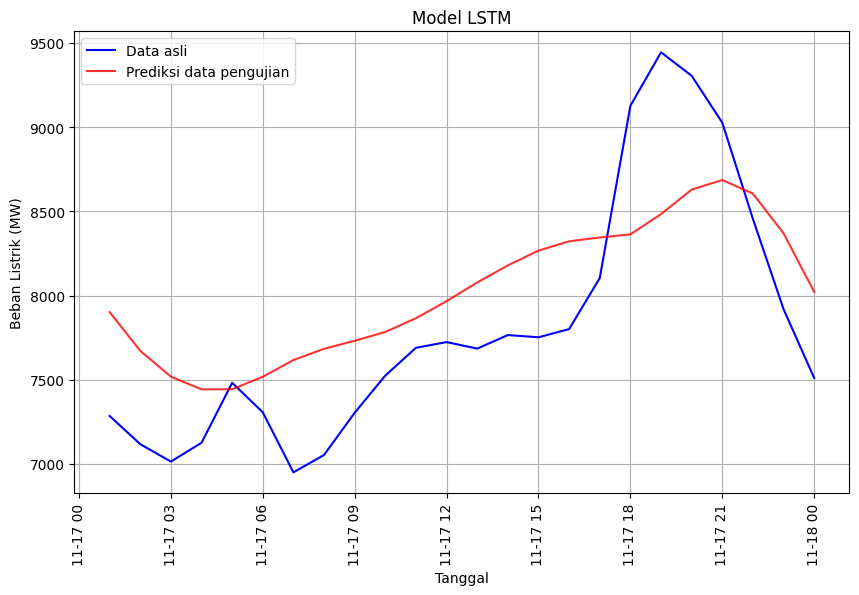

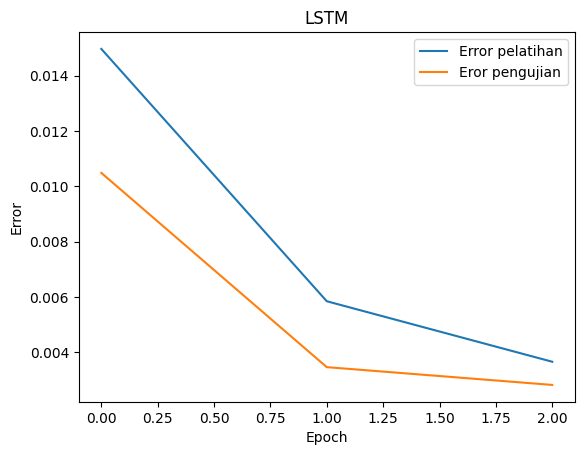

In [30]:
title = "LSTM"
type = "trial"
best_epochs = np.argmin(history_lstm.history['val_loss']) + 1
history = history_lstm

train_predict_lstm, test_predict_lstm, mse_train, mse_test = evaluasi(X_train, X_test, y_train, y_test, TIME_STEP, model_lstm, scaler, [True, "(Trial) LSTM", TIME_STEP, layer, dense, dropout_rate, int(best_epochs), batch_size], verbose=True)

train_predict = train_predict_lstm
test_predict = test_predict_lstm
days = TIME_STEP

simpan_histori(history_data=history, filename="LSTM_loss", type=type, time_step=TIME_STEP)
plot_evaluasi(time=df_siap['TANGGAL_JAM'], data_asli=df_siap['BEBAN'], train_predict=train_predict, test_predict=test_predict, scaler=scaler, title=title, filename="LSTM_train_test", type=type, time_step=TIME_STEP)
plot_prediksi(time=df_siap['TANGGAL_JAM'], data_asli=df_siap['BEBAN'], train_predict=train_predict, test_predict=test_predict, scaler=scaler, days=24, title=title, filename="LSTM_test", type=type, time_step=TIME_STEP)
plot_loss(history=history, epochs=best_epochs, title=title, filename="LSTM_Loss", type=type, time_step=TIME_STEP)

---
### **BiLSTM**
---

486/486 [==============================] - 8s 17ms/step
Saving history
✅ Data berhasil disimpan ke sheet 'raw' di ../hasil/pemodelan/hasil_eksperimen.xlsx
Matriks Evaluasi : Train	Test
MSE : 165699.77872107763	211838.3239061992
MAE : 333.04055891752	363.67908686004625
RMSE : 407.0623769412713	460.2589748241735
MAPE : 0.049907182368892	0.044396654932941926
R2 : 0.8240413300919035	0.7936466142076438


C:\Users\Lab Matematika\AppData\Local\Temp\ipykernel_22524\2040627452.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, best_epoch_data], ignore_index=True)


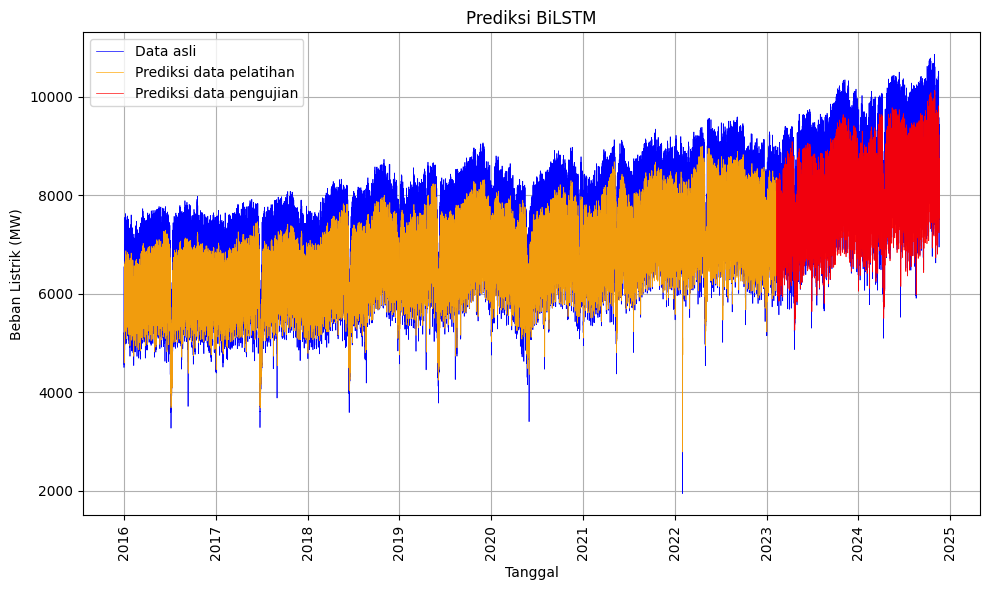

C:\Users\Lab Matematika\AppData\Local\Temp\ipykernel_22524\1031969864.py:11: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=days)


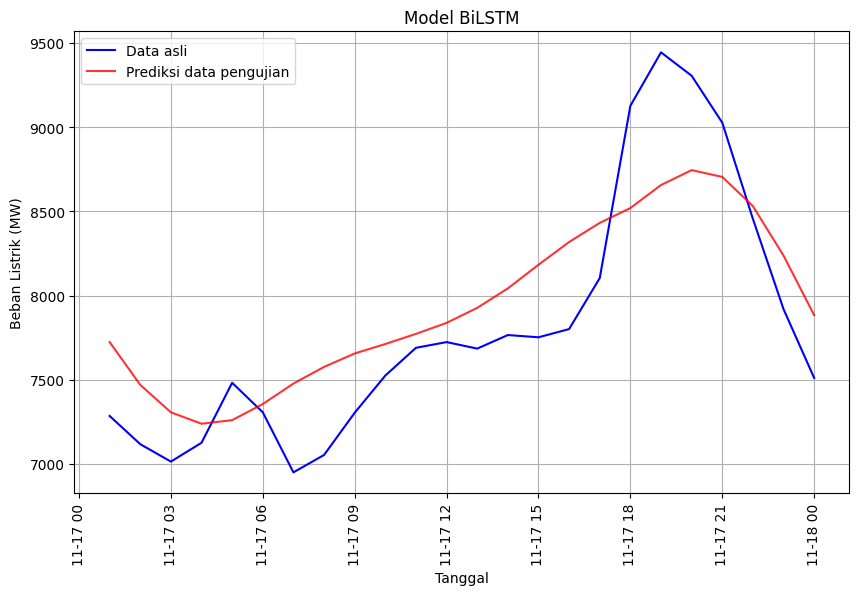

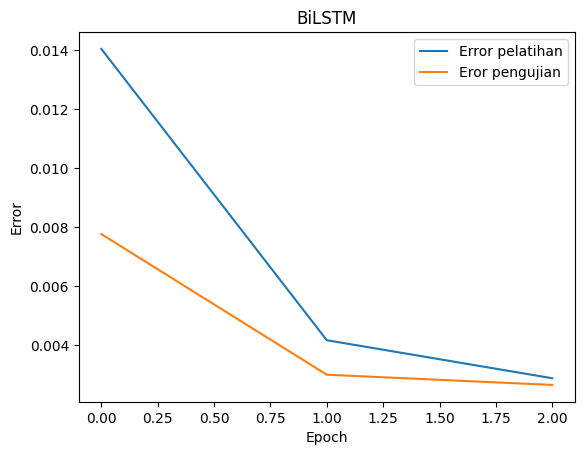

In [32]:
title = "BiLSTM"
type = "trial"
best_epochs = np.argmin(history_bilstm.history['val_loss']) + 1
history = history_bilstm

train_predict_bilstm, test_predict_bilstm, mse_train, mse_test = evaluasi(X_train, X_test, y_train, y_test, TIME_STEP, model_bilstm, scaler, [True, "(Trial) BiLSTM", TIME_STEP, layer, dense, dropout_rate, int(best_epochs), batch_size], verbose=True)

train_predict = train_predict_bilstm
test_predict = test_predict_bilstm
days = TIME_STEP

simpan_histori(history_data=history, filename="BiLSTM_loss", type=type, time_step=TIME_STEP)
plot_evaluasi(time=df_siap['TANGGAL_JAM'], data_asli=df_siap['BEBAN'], train_predict=train_predict, test_predict=test_predict, scaler=scaler, title=title, filename="BiLSTM_train_test", type=type, time_step=TIME_STEP)
plot_prediksi(time=df_siap['TANGGAL_JAM'], data_asli=df_siap['BEBAN'], train_predict=train_predict, test_predict=test_predict, scaler=scaler, days=24, title=title, filename="BiLSTM_test", type=type, time_step=TIME_STEP)
plot_loss(history=history, epochs=best_epochs, title=title, filename="BiLSTM_Loss", type=type, time_step=TIME_STEP)

---
### **GRU**
---

486/486 [==============================] - 2s 3ms/step
Saving history
✅ Data berhasil disimpan ke sheet 'raw' di ../hasil/pemodelan/hasil_eksperimen.xlsx
Matriks Evaluasi : Train	Test
MSE : 105669.73687194142	172630.1220874654
MAE : 243.79411710839977	298.91066717910866
RMSE : 325.0688186706646	415.48781220087
MAPE : 0.03625858623656344	0.03573933935478972
R2 : 0.8877879795295375	0.8318396363320306


C:\Users\Lab Matematika\AppData\Local\Temp\ipykernel_22524\2040627452.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, best_epoch_data], ignore_index=True)


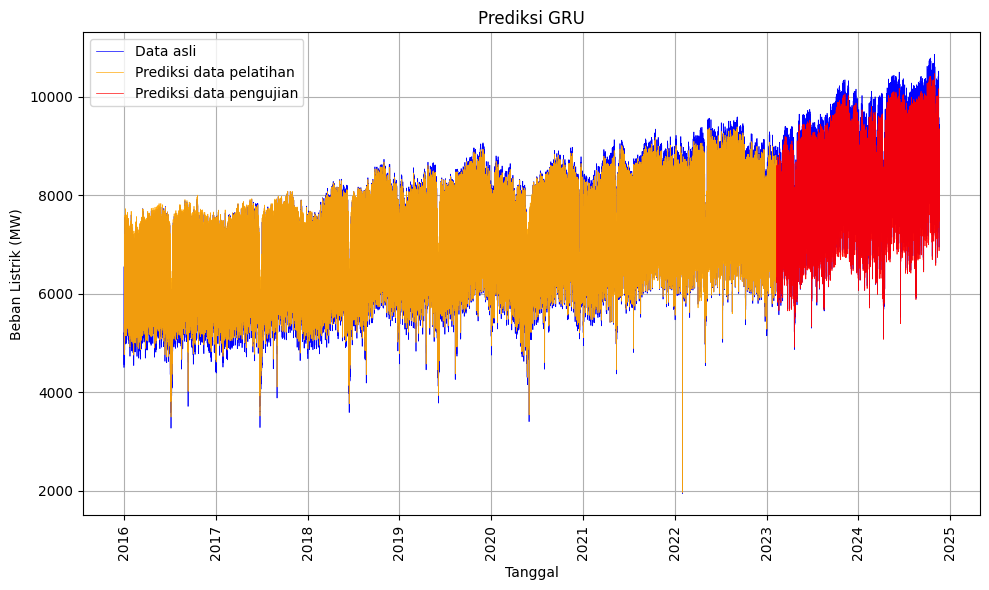

C:\Users\Lab Matematika\AppData\Local\Temp\ipykernel_22524\1031969864.py:11: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=days)


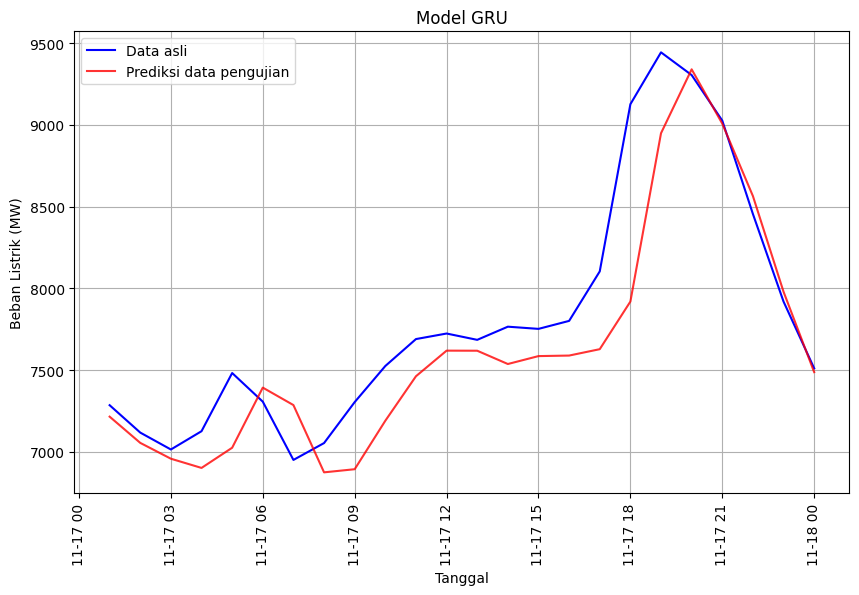

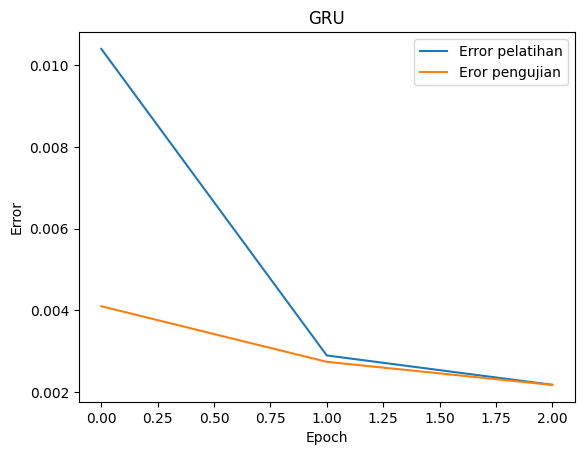

In [34]:
title = "GRU"
type = "trial"
best_epochs = np.argmin(history_gru.history['val_loss']) + 1
history = history_gru

train_predict_gru, test_predict_gru, mse_train, mse_test = evaluasi(X_train, X_test, y_train, y_test, TIME_STEP, model_gru, scaler, [True, "(Trial) GRU", TIME_STEP, layer, dense, dropout_rate, int(best_epochs), batch_size], verbose=True)

train_predict = train_predict_gru
test_predict = test_predict_gru
days = TIME_STEP

simpan_histori(history_data=history, filename="GRU_loss", type=type, time_step=TIME_STEP)
plot_evaluasi(time=df_siap['TANGGAL_JAM'], data_asli=df_siap['BEBAN'], train_predict=train_predict, test_predict=test_predict, scaler=scaler, title=title, filename="GRU_train_test", type=type, time_step=TIME_STEP)
plot_prediksi(time=df_siap['TANGGAL_JAM'], data_asli=df_siap['BEBAN'], train_predict=train_predict, test_predict=test_predict, scaler=scaler, days=24, title=title, filename="GRU_test", type=type, time_step=TIME_STEP)
plot_loss(history=history, epochs=best_epochs, title=title, filename="GRU_Loss", type=type, time_step=TIME_STEP)

---
# **ALL IN ONE**
---

In [28]:
df_siap = pd.read_csv(METADATA_PATH)
df_siap['TANGGAL_JAM'] = pd.to_datetime(df_siap['TANGGAL_JAM'])
df_siap['TAHUN'] = df_siap['TANGGAL_JAM'].dt.year

In [31]:
def lstm_semua(title, time_step, parameter):
  # Pembagian data
  training_size = int(len(data) * 0.8)
  train_data_asli, test_data_asli, X_train_asli, X_test_asli, y_train_asli, y_test_asli, scaler_asli = bagi_data(df_siap, training_size, time_step, MinMaxScaler(feature_range=(0, 1)))

  # Pembuatan struktur model
  layer, dense, dropout_rate, batch_size = parameter
  model, early_stopping = build_lstm(layer, dense, dropout_rate, time_step)

  # Pelatihan model
  history = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

  # Evaluasi
  title = "LSTM"
  type = "semua"
  best_epochs = np.argmin(history.history['val_loss']) + 1
  history = history

  train_predict, test_predict, mse_train, mse_test = evaluasi(X_train, X_test, y_train, y_test, TIME_STEP, model, scaler, [True, f"{title} {time_step}", TIME_STEP, layer, dense, dropout_rate, int(best_epochs), batch_size], verbose=True)

  train_predict = train_predict
  test_predict = test_predict
  days = TIME_STEP

  plot_evaluasi(time=df_siap['TANGGAL_JAM'], data_asli=df_siap['BEBAN'], train_predict=train_predict, test_predict=test_predict, scaler=scaler, title=title, filename="LSTM_train_test", type=type, time_step=TIME_STEP)
  plot_prediksi(time=df_siap['TANGGAL_JAM'], data_asli=df_siap['BEBAN'], train_predict=train_predict, test_predict=test_predict, scaler=scaler, days=24, title=title, filename="LSTM_test", type=type, time_step=TIME_STEP)
  plot_loss(history=history, epochs=best_epochs, title=title, filename="LSTM_Loss", type=type, time_step=TIME_STEP)
  simpan_histori(history_data=history, filename="LSTM_loss", type=type, time_step=TIME_STEP)

  model.save(f"{MODEL_PATH}/{time_step}/LSTM/semua_{title}.h5")

def bilstm_semua(title, time_step, parameter):
  # Pembagian data
  training_size = int(len(data) * 0.8)
  train_data_asli, test_data_asli, X_train_asli, X_test_asli, y_train_asli, y_test_asli, scaler_asli = bagi_data(df_siap, training_size, time_step, MinMaxScaler(feature_range=(0, 1)))

  # Pembuatan struktur model
  layer, dense, dropout_rate, batch_size = parameter
  model, early_stopping = build_bilstm(layer, dense, dropout_rate, time_step)

  # Pelatihan model
  history = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

  # Evaluasi
  title = "BiLSTM"
  type = "semua"
  best_epochs = np.argmin(history.history['val_loss']) + 1
  history = history

  train_predict, test_predict, mse_train, mse_test = evaluasi(X_train, X_test, y_train, y_test, TIME_STEP, model, scaler, [True, f"{title} {time_step}", TIME_STEP, layer, dense, dropout_rate, int(best_epochs), batch_size], verbose=True)

  train_predict = train_predict
  test_predict = test_predict
  days = TIME_STEP

  plot_evaluasi(time=df_siap['TANGGAL_JAM'], data_asli=df_siap['BEBAN'], train_predict=train_predict, test_predict=test_predict, scaler=scaler, title=title, filename="BiLSTM_train_test", type=type, time_step=TIME_STEP)
  plot_prediksi(time=df_siap['TANGGAL_JAM'], data_asli=df_siap['BEBAN'], train_predict=train_predict, test_predict=test_predict, scaler=scaler, days=24, title=title, filename="BiLSTM_test", type=type, time_step=TIME_STEP)
  plot_loss(history=history, epochs=best_epochs, title=title, filename="BiLSTM_Loss", type=type, time_step=TIME_STEP)
  simpan_histori(history_data=history, filename="BiLSTM_loss", type=type, time_step=TIME_STEP)

  model.save(f"{MODEL_PATH}/{time_step}/BiLSTM/semua_{title}.h5")


def gru_semua(title, time_step, parameter):
  # Pembagian data
  training_size = int(len(data) * 0.8)
  train_data_asli, test_data_asli, X_train_asli, X_test_asli, y_train_asli, y_test_asli, scaler_asli = bagi_data(df_siap, training_size, time_step, MinMaxScaler(feature_range=(0, 1)))

  # Pembuatan struktur model
  layer, dense, dropout_rate, batch_size = parameter
  model, early_stopping = build_gru(layer, dense, dropout_rate, time_step)

  # Pelatihan model
  history = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

  # Evaluasi
  title = "GRU"
  type = "semua"
  best_epochs = np.argmin(history.history['val_loss']) + 1
  history = history

  train_predict, test_predict, mse_train, mse_test = evaluasi(X_train, X_test, y_train, y_test, TIME_STEP, model, scaler, [True, f"{title} {time_step}", TIME_STEP, layer, dense, dropout_rate, int(best_epochs), batch_size], verbose=True)

  train_predict = train_predict
  test_predict = test_predict
  days = TIME_STEP

  plot_evaluasi(time=df_siap['TANGGAL_JAM'], data_asli=df_siap['BEBAN'], train_predict=train_predict, test_predict=test_predict, scaler=scaler, title=title, filename="GRU_train_test", type=type, time_step=TIME_STEP)
  plot_prediksi(time=df_siap['TANGGAL_JAM'], data_asli=df_siap['BEBAN'], train_predict=train_predict, test_predict=test_predict, scaler=scaler, days=24, title=title, filename="GRU_test", type=type, time_step=TIME_STEP)
  plot_loss(history=history, epochs=best_epochs, title=title, filename="GRU_Loss", type=type, time_step=TIME_STEP)
  simpan_histori(history_data=history, filename="GRU_loss", type=type, time_step=TIME_STEP)

  model.save(f"{MODEL_PATH}/{time_step}/GRU/semua_{title}.h5")

Epoch 1/200
122/122 [==============================] - 5s 17ms/step - loss: 0.0125 - val_loss: 0.0043
Epoch 2/200
122/122 [==============================] - 2s 13ms/step - loss: 0.0031 - val_loss: 0.0023
Epoch 3/200
122/122 [==============================] - 2s 14ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 4/200
122/122 [==============================] - 2s 13ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 5/200
122/122 [==============================] - 2s 13ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 6/200
122/122 [==============================] - 2s 13ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 7/200
122/122 [==============================] - 2s 13ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 8/200
122/122 [==============================] - 2s 13ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 9/200
122/122 [==============================] - 2s 13ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 10/200
122/122 [==============================] - 2s 14ms/step - loss: 0.001

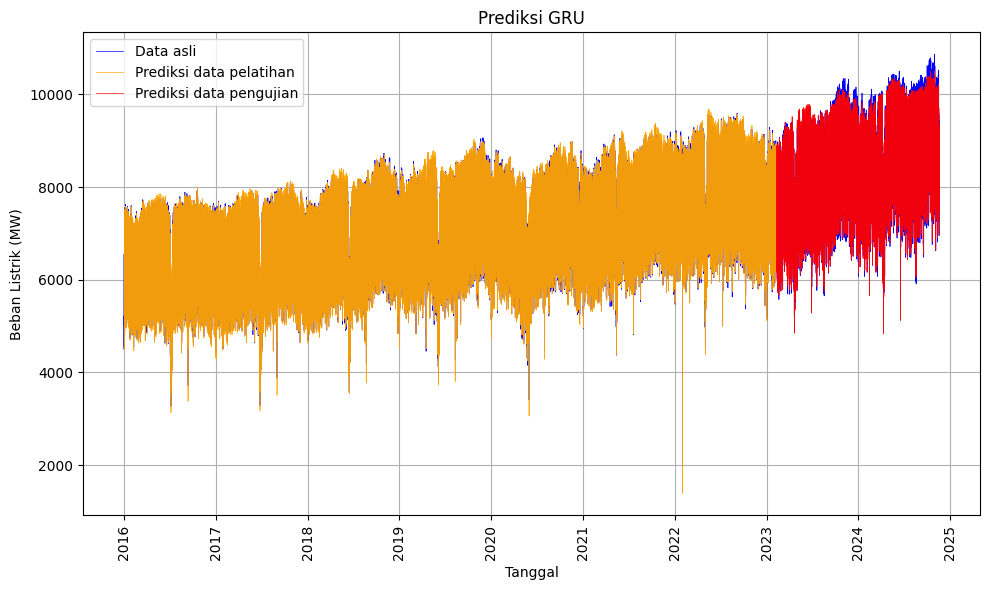

C:\Users\Lab Matematika\AppData\Local\Temp\ipykernel_19040\1031969864.py:11: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=days)


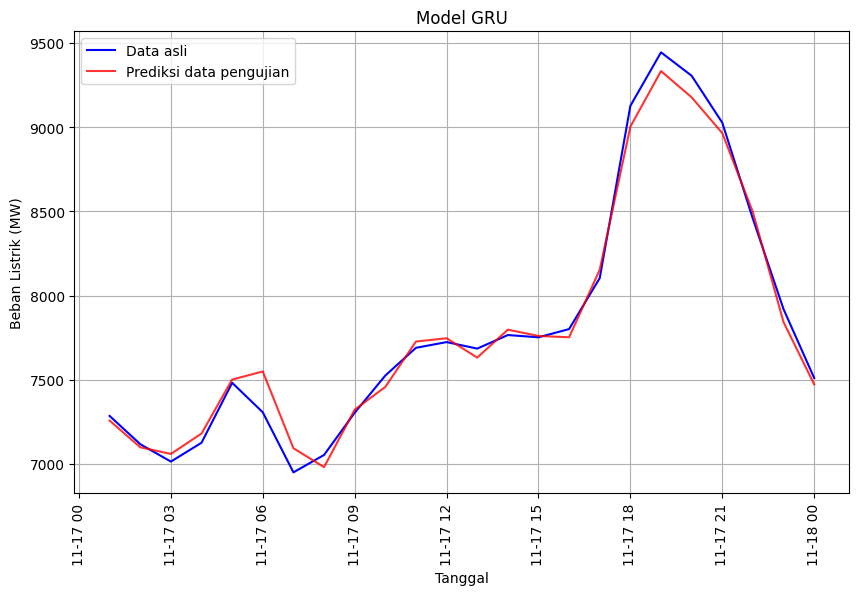

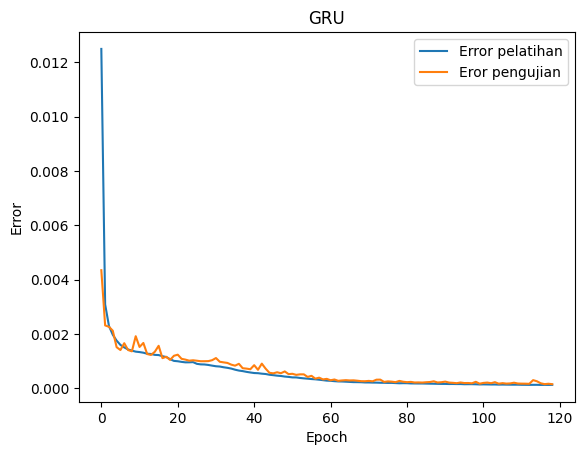

C:\Users\Lab Matematika\AppData\Local\Temp\ipykernel_19040\2040627452.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, best_epoch_data], ignore_index=True)


In [32]:
parameters = [
    # [title, time_step, [layers, dense, dropout_rate, batch_size]]
    [f'GRU_24', 24, [2, [116, 104], 0.1, 512]],
    # [f'GRU_168_{TRIAL}', 168, [2, [114, 113], 0.1, 256]],
]

for parameter in parameters:
  history_gru = gru_semua(parameter[0], parameter[1], parameter[2])


---
# **HYPERPARAMETER TUNING**
---

In [16]:
df_siap = pd.read_csv(METADATA_PATH)
df_siap['TANGGAL_JAM'] = pd.to_datetime(df_siap['TANGGAL_JAM'])
df_siap['TAHUN'] = df_siap['TANGGAL_JAM'].dt.year

In [17]:
UKURAN_PELATIHAN = int(len(df_siap) * 0.8)
R_LAYER = [1, 5]
R_DENSE = [16, 128]
R_DROPOUT_RATE = [0.1, 0.5]
R_BATCH_SIZE = [256, 512, 1024, 2048]
EPOCHS = 200

In [19]:
def objective_lstm(trial, data, time_step):
  try:
    # Pembagian data
    training_size = UKURAN_PELATIHAN
    train_data, test_data, X_train, X_test, y_train, y_test, scaler = bagi_data(data, training_size, time_step, MinMaxScaler(feature_range=(0, 1)))

    # Pembuatan struktur model
    layer = trial.suggest_int('nn_layer', R_LAYER[0], R_LAYER[1])
    dense = []
    for i in range(layer):
        dense.append(trial.suggest_int(f'dense_{i}', R_DENSE[0], R_DENSE[1]))

    dropout_rate = trial.suggest_float('dropout_rate', R_DROPOUT_RATE[0], R_DROPOUT_RATE[1], step=0.1)
    time_step = time_step

    model, early_stooping = build_lstm(layer, dense, dropout_rate, time_step)

    # Pelatihan model
    batch_size = trial.suggest_categorical('batch_size', [256, 512, 1024, 2048])
    epochs = EPOCHS
    print(f"Hiperparameter (layer : {layer}, dense : {dense}, dropout rate : {dropout_rate}, batch size = {batch_size})")
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stooping], verbose=2)

    # Evaluasi
    best_epochs = np.argmin(history.history['val_loss']) + 1
    train_predict, test_predict, mse_train, mse_test = evaluasi(X_train, X_test, y_train, y_test, time_step, model, scaler, [True, f'LSTM_{trial.number}', time_step, layer, dense, dropout_rate, int(best_epochs), batch_size], False)
    
    simpan_histori(history_data=history, filename="optuna_{trial.number}_LSTM_{layer}_{dense}", type="optuna", time_step=TIME_STEP)
    model.save(f"{MODEL_PATH}/{time_step}/LSTM/optuna_{trial.number}_LSTM_{layer}_{dense}.h5")

    return mse_test

  except Exception as e:
    print(f"Error in trial {trial.number}: {e}")
    raise

def objective_bilstm(trial, data, time_step):
  try:
    # Pembagian data
    training_size = UKURAN_PELATIHAN
    train_data, test_data, X_train, X_test, y_train, y_test, scaler = bagi_data(data, training_size, time_step, MinMaxScaler(feature_range=(0, 1)))

    # Pembuatan struktur model
    layer = trial.suggest_int('nn_layer', R_LAYER[0], R_LAYER[1])
    dense = []
    for i in range(layer):
        dense.append(trial.suggest_int(f'dense_{i}', R_DENSE[0], R_DENSE[1]))

    dropout_rate = trial.suggest_float('dropout_rate', R_DROPOUT_RATE[0], R_DROPOUT_RATE[1], step=0.1)
    time_step = time_step

    model, early_stooping = build_bilstm(layer, dense, dropout_rate, time_step)

    # Pelatihan model
    batch_size = trial.suggest_categorical('batch_size', R_BATCH_SIZE)
    epochs = EPOCHS
    print(f"Hiperparameter (layer : {layer}, dense : {dense}, dropout rate : {dropout_rate}, batch size = {batch_size})")
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stooping], verbose=2)

    # Evaluasi model
    best_epochs = np.argmin(history.history['val_loss']) + 1
    train_predict, test_predict, mse_train, mse_test = evaluasi(X_train, X_test, y_train, y_test, time_step, model, scaler, [True, f'BiLSTM_{trial.number}', time_step, layer, dense, dropout_rate, int(best_epochs), batch_size], False)
    
    simpan_histori(history_data=history, filename="optuna_{trial.number}_BiLSTM_{layer}_{dense}", type="optuna", time_step=TIME_STEP)
    model.save(f"{MODEL_PATH}/{time_step}/BiLSTM/optuna_{trial.number}_BiLSTM_{layer}_{dense}.h5")

    return mse_test
  except Exception as e:
    print(f"Error in trial {trial.number}: {e}")
    raise

def objective_gru(trial, data, time_step):
  try:
    # Pembagian data
    training_size = int(len(data) * 0.8)
    train_data, test_data, X_train, X_test, y_train, y_test, scaler = bagi_data(data, training_size, time_step, MinMaxScaler(feature_range=(0, 1)))

    # Pembuatan struktur model
    layer = trial.suggest_int('nn_layer', R_LAYER[0], R_LAYER[1])
    dense = []
    for i in range(layer):
        dense.append(trial.suggest_int(f'dense_{i}', R_DENSE[0], R_DENSE[1]))
    dropout_rate = trial.suggest_float('dropout_rate', R_DROPOUT_RATE[0], R_DROPOUT_RATE[1], step=0.1)
    time_step = time_step

    model, early_stooping = build_gru(layer, dense, dropout_rate, time_step)

    # Pelatihan model
    batch_size = trial.suggest_categorical('batch_size', R_BATCH_SIZE)
    epochs = EPOCHS
    print(f"Hiperparameter (layer : {layer}, dense : {dense}, dropout rate : {dropout_rate}, batch size = {batch_size})")
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stooping], verbose=2)

    # Evaluasi
    best_epochs = np.argmin(history.history['val_loss']) + 1
    train_predict, test_predict, mse_train, mse_test = evaluasi(X_train, X_test, y_train, y_test, time_step, model, scaler, [True, f'GRU_{trial.number}', time_step, layer, dense, dropout_rate, int(best_epochs), batch_size], False)
    
    simpan_histori(history_data=history, filename="optuna_{trial.number}_GRU_{layer}_{dense}", type="optuna", time_step=TIME_STEP)
    model.save(f"{MODEL_PATH}/{time_step}/GRU/optuna_{trial.number}_BiLSTM_{layer}_{dense}.h5")

    return mse_test
  except Exception as e:
    print(f"Error in trial {trial.number}: {e}")
    raise

---
## **LSTM**
---

In [46]:
for time_step in [24, 168]:
    study_lstm = study = optuna.create_study(study_name="study_lstm", storage=f"sqlite:///{OPTUNA_PATH}/lstm_{time_step}.db", load_if_exists=True, direction='minimize')
    study_lstm.optimize(lambda trial: objective_lstm(trial, data=df_siap, time_step=time_step), n_trials=50, n_jobs=5)
    print("Hiperparameter terbaik: ", study_lstm.best_params)
    print("MSE terbaik: ", study_lstm.best_value)
    del study_lstm

[I 2025-10-20 08:34:37,642] Using an existing study with name 'study_lstm' instead of creating a new one.


Hiperparameter (layer : 1, dense : [35], dropout rate : 0.5, batch size = 512)
Epoch 1/200
Hiperparameter (layer : 2, dense : [69, 22], dropout rate : 0.2, batch size = 512)
Epoch 1/200
122/122 - 4s - loss: 0.0396 - val_loss: 0.0157 - 4s/epoch - 30ms/step
Epoch 2/200
122/122 - 2s - loss: 0.0155 - val_loss: 0.0135 - 2s/epoch - 14ms/step
Epoch 3/200
122/122 - 6s - loss: 0.0239 - val_loss: 0.0148 - 6s/epoch - 47ms/step
Epoch 2/200
122/122 - 1s - loss: 0.0134 - val_loss: 0.0110 - 1s/epoch - 10ms/step
Epoch 4/200
122/122 - 2s - loss: 0.0117 - val_loss: 0.0102 - 2s/epoch - 14ms/step
Epoch 5/200
122/122 - 2s - loss: 0.0112 - val_loss: 0.0119 - 2s/epoch - 19ms/step
Epoch 3/200
122/122 - 2s - loss: 0.0102 - val_loss: 0.0042 - 2s/epoch - 16ms/step
Epoch 6/200
122/122 - 2s - loss: 0.0096 - val_loss: 0.0060 - 2s/epoch - 20ms/step
Epoch 4/200
122/122 - 2s - loss: 0.0083 - val_loss: 0.0027 - 2s/epoch - 14ms/step
Epoch 7/200
122/122 - 2s - loss: 0.0067 - val_loss: 0.0032 - 2s/epoch - 19ms/step
Epoch 

C:\Users\Lab Matematika\AppData\Local\Temp\ipykernel_22524\2040627452.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, best_epoch_data], ignore_index=True)
[I 2025-10-20 08:36:25,287] Trial 3 finished with value: 82335.27565859469 and parameters: {'nn_layer': 1, 'dense_0': 35, 'dropout_rate': 0.5, 'batch_size': 512}. Best is trial 3 with value: 82335.27565859469.


✅ Data berhasil disimpan ke sheet 'raw' di ../hasil/pemodelan/hasil_eksperimen.xlsx
122/122 - 2s - loss: 8.3841e-04 - val_loss: 0.0010 - 2s/epoch - 13ms/step
Epoch 50/200
Hiperparameter (layer : 5, dense : [42, 74, 124, 102, 95], dropout rate : 0.4, batch size = 1024)
Epoch 1/200
122/122 - 1s - loss: 8.2722e-04 - val_loss: 9.3907e-04 - 1s/epoch - 12ms/step
Epoch 51/200
122/122 - 2s - loss: 8.1188e-04 - val_loss: 0.0012 - 2s/epoch - 15ms/step
Epoch 52/200
122/122 - 1s - loss: 8.1600e-04 - val_loss: 9.9797e-04 - 1s/epoch - 11ms/step
Epoch 53/200
122/122 - 3s - loss: 7.9471e-04 - val_loss: 0.0011 - 3s/epoch - 23ms/step
Epoch 54/200
122/122 - 3s - loss: 7.9239e-04 - val_loss: 0.0011 - 3s/epoch - 21ms/step
Epoch 55/200
61/61 - 10s - loss: 0.0298 - val_loss: 0.0204 - 10s/epoch - 168ms/step
Epoch 2/200
61/61 - 4s - loss: 0.0123 - val_loss: 0.0201 - 4s/epoch - 64ms/step
122/122 - 5s - loss: 7.6943e-04 - val_loss: 9.8603e-04 - 5s/epoch - 37ms/step
Epoch 3/200
Epoch 56/200
61/61 - 4s - loss: 0.0

---
## **BiLSTM**
---

In [ ]:
for time_step in [24, 168]:
    study_bilstm = study = optuna.create_study(study_name="study_bilstm", storage=f"sqlite:///{OPTUNA_PATH}/bilstm_{time_step}.db", load_if_exists=True, direction='minimize')
    study_bilstm.optimize(lambda trial: objective_bilstm(trial, data=df_siap, time_step=time_step), n_trials=50, n_jobs=5)
    print("Hiperparameter terbaik: ", study_bilstm.best_params)
    print("MSE terbaik: ", study_bilstm.best_value)
    del study_bilstm

---
## **GRU**
---

In [ ]:
for time_step in [24, 168]:
    study_gru = study = optuna.create_study(study_name="study_gru", storage=f"sqlite:///{OPTUNA_PATH}/gru_{time_step}.db", load_if_exists=True, direction='minimize')
    study_gru.optimize(lambda trial: objective_gru(trial, data=df_siap, time_step=time_step), n_trials=50, n_jobs=5)
    print("Hiperparameter terbaik: ", study_gru.best_params)
    print("MSE terbaik: ", study_gru.best_value)
    del study_gru

---
## **Visualisasi Optuna**
---

In [21]:
def plot_optuna(df, title):
    study = optuna.create_study(direction='minimize')  # Jika kamu ingin meminimalkan fungsi

    # Menentukan distribusi parameter
    distributions = {
        'params_batch_size': optuna.distributions.CategoricalDistribution([256, 512, 1024, 2048]),
        'params_dense_0': optuna.distributions.IntDistribution(0, 128),
        'params_dense_1': optuna.distributions.IntDistribution(0, 128),
        'params_dense_2': optuna.distributions.IntDistribution(0, 128),
        'params_dense_3': optuna.distributions.IntDistribution(0, 128),
        'params_dense_4': optuna.distributions.IntDistribution(0, 128),
        'params_dropout_rate': optuna.distributions.FloatDistribution(0.1, 0.5, step=0.1),
        'params_nn_layer': optuna.distributions.IntDistribution(1, 5)
    }

    # Menambahkan trial berdasarkan dataframe
    for _, row in df.iterrows():
        trial = optuna.trial.FrozenTrial(
            number=row['number'],
            value=row['value'],
            params=row.drop(['value', 'number','datetime_start','datetime_complete', 'state','duration']).to_dict(),  # Parameters excluding 'value' and 'number'
            datetime_start=row['datetime_start'],
            datetime_complete=row['datetime_complete'],
            state=optuna.trial.TrialState.COMPLETE,
            distributions=distributions,  # Menambahkan distribusi yang sesuai
            user_attrs={},     # Empty dict for user_attrs
            system_attrs={},   # Empty dict for system_attrs
            intermediate_values={},  # Empty dict for intermediate_values
            trial_id=row['number']  # Set trial_id to 'number' or any unique identifier
        )
        study.add_trial(trial)

    # Menyiapkan plot untuk visualisasi
    plots = [
        (plot_optimization_history, f"Histori optimisasi - iterasi vs MSE uji {title[0]}", f"Output/Grafik/Optuna/{title[1]}_optimization_history.png"),
        (plot_param_importances, f"Parameter penting untuk MSE uji {title[0]}", f"Output/Grafik/Optuna/{title[1]}_param_importances.png"),
        (plot_parallel_coordinate, f"Koordinat paralel dari parameter and MSE uji {title[0]}", f"Output/Grafik/Optuna/{title[1]}_parallel_coordinate.png"),
        (plot_slice, f"Plot terpisah dari parameter and MSE uji {title[0]}", f"Output/Grafik/Optuna/{title[1]}_slice_plot.png"),
        (plot_contour, f"Plot kontur dari parameter and MSE uji {title[0]}", f"Output/Grafik/Optuna/{title[1]}_contour_plot.png"),
        (plot_optimization_history, f"Histori optimisasi - iterasi vs MSE uji {title[0]}", f"Output/Grafik/Optuna/{title[1]}_optimization_history.pdf"),
        (plot_param_importances, f"Parameter penting untuk MSE uji {title[0]}", f"Output/Grafik/Optuna/{title[1]}_param_importances.pdf"),
        (plot_parallel_coordinate, f"Koordinat paralel dari parameter and MSE uji {title[0]}", f"Output/Grafik/Optuna/{title[1]}_parallel_coordinate.pdf"),
        (plot_slice, f"Plot terpisah dari parameter and MSE uji {title[0]}", f"Output/Grafik/Optuna/{title[1]}_slice_plot.pdf"),
        (plot_contour, f"Plot kontur dari parameter and MSE uji {title[0]}", f"Output/Grafik/Optuna/{title[1]}_contour_plot.pdf")
    ]

    # Menampilkan dan menyimpan plot
    for plot_func, plot_title, save_path in plots:
        fig = plot_func(study)
        fig.update_layout(title=plot_title)
        fig.show()
        fig.write_image("test.png",engine='orca')
        print(f"Plot '{plot_title}' disimpan sebagai {save_path}")

In [ ]:
df_lstm_24 = pd.read_csv("Input/Data/Optuna/optuna_lstm_24.csv")
df_bilstm_24 = pd.read_csv("Input/Data/Optuna/optuna_bilstm_24.csv")
df_gru_24 = pd.read_csv("Input/Data/Optuna/optuna_gru_24.csv")
df_lstm_168 = pd.read_csv("Input/Data/Optuna/optuna_lstm_168.csv")
df_bilstm_168 = pd.read_csv("Input/Data/Optuna/optuna_bilstm_168.csv")
df_gru_168 = pd.read_csv("Input/Data/Optuna/optuna_gru_168.csv")

In [ ]:
plot_optuna(df_lstm_24, ["LSTM (time step 24)", "lstm_24"])